In [1]:
import warnings

warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import shap

from lightgbm import LGBMRanker, LGBMClassifier
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple

from tools import avg_user_metric

### Подготовка данных

In [2]:
interactions = pd.read_csv('../data/interactions.csv')
items = pd.read_csv('../data/items.csv')
users = pd.read_csv('../data/users.csv')

In [3]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [4]:
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    },
    inplace=True,
)
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

interactions_default_values: Dict[str, Any] = {
    Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [5]:
interactions.describe(datetime_is_numeric=True)

,user_id,item_id,datetime,total_dur,weight
count,5.476251e+06,5.476251e+06,5476251,5.476251e+06,5.476251e+06
mean,5.491159e+05,8.485860e+03,2021-06-23 11:56:04.296268032,8.295490e+03,4.636699e+01
min,0.000000e+00,0.000000e+00,2021-03-13 00:00:00,1.000000e+00,0.000000e+00
25%,2.750140e+05,4.326000e+03,2021-05-25 00:00:00,3.710000e+02,4.000000e+00
50%,5.493640e+05,8.776000e+03,2021-07-01 00:00:00,2.898000e+03,3.200000e+01
75%,8.227540e+05,1.254400e+04,2021-07-30 00:00:00,7.116000e+03,1.000000e+02
max,1.097557e+06,1.651800e+04,2021-08-22 00:00:00,8.041167e+07,1.000000e+02
std,3.166077e+05,4.740762e+03,NaN,4.856799e+04,4.191923e+01


In [6]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [7]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding


users_cat_cols = [
    'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [8]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [9]:
users.describe(include='category')

,age,income,sex,kids_flg
count,840197,840197,840197,840197
unique,7,7,3,2
top,1,2,0,0
freq,233926,471519,425270,587209


In [10]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [11]:
items_cat_cols = [
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating',
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [12]:
items.describe(include='all')

,item_id,content_type,release_year,for_kids,age_rating,studios
count,15963.000000,15963.0,15963.000000,15963.0,15963.000000,15963.0
unique,NaN,2.0,NaN,3.0,NaN,39.0
top,NaN,0.0,NaN,-1.0,NaN,-1.0
freq,NaN,12002.0,NaN,15397.0,NaN,14898.0
mean,8268.453424,NaN,2007.969492,NaN,12.945937,NaN
std,4773.841513,NaN,16.835890,NaN,5.495760,NaN
min,0.000000,NaN,1897.000000,NaN,0.000000,NaN
25%,4141.500000,NaN,2007.000000,NaN,12.000000,NaN
50%,8266.000000,NaN,2014.000000,NaN,16.000000,NaN
75%,12414.500000,NaN,2018.000000,NaN,16.000000,NaN


## Трейн-вал-тест сплит

In [13]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


### Схема валидации с разбиением по юзерам (удобна для первого запуска в  проде)

In [14]:
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

train_size = 0.7
val_size = 0.15
test_size = 0.15

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)
)

In [15]:
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

## Read LightFM candidates

In [16]:
lfm_candidates = pd.read_csv('lfm_candidates.csv')

## Add PopularModel

In [17]:
from rectools.models import PopularModel
from rectools.dataset import Dataset

dataset = Dataset.construct(base_models_data)
popular_model = PopularModel()
popular_model.fit(dataset)

In [18]:
n_items = items[Columns.Item].nunique()
popular_candidates = popular_model.recommend(
    users=dataset.user_id_map.external_ids[:1], dataset=dataset, k=n_items, filter_viewed=True
)
popular_candidates.rename({"rank": "pop_rank", "score": "pop_score"}, axis=1, inplace=True)
popular_candidates.drop(Columns.User, axis=1, inplace=True)
popular_candidates.head()

,item_id,pop_score,pop_rank
0,10440,141889.0,1
1,15297,137128.0,2
2,13865,93403.0,3
3,4151,69641.0,4
4,2657,55146.0,5


## Merging candidates

In [19]:
candidates = lfm_candidates.merge(popular_candidates, how="left", on=[Columns.Item])
candidates.head()

,Unnamed: 0,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,0,176549,15297,-0.000030,1,137128.0,2.0
1,1,176549,10440,-0.000031,2,141889.0,1.0
2,2,176549,13865,-0.000033,3,93403.0,3.0
3,3,176549,4151,-0.000033,4,69641.0,4.0
4,4,176549,3734,-0.000034,5,50004.0,6.0


In [20]:
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k=10),
        'map@10': MAP(k=10),
        'Precision@10': Precision(k=10),
        'recall@10': Recall(k=10),
        'novelty@10': MeanInvUserFreq(k=10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ),
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

In [21]:
models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['lfm'] = calc_metrics_(candidates, 'lfm_rank')

In [22]:
models_metrics['pop'] = calc_metrics_(candidates, 'pop_rank')

In [23]:
models_metrics

{'lfm': {'Precision@10': 0.024970454161742366,
  'recall@10': 0.08358776021147662,
  'ndcg@10': 0.03163934182760983,
  'map@10': 0.042556196036179696,
  'novelty@10': 3.1351389278275326},
 'pop': {'Precision@10': 0.01955397295596519,
  'recall@10': 0.06567592267978621,
  'ndcg@10': 0.02416983974819715,
  'map@10': 0.03136498967480883,
  'novelty@10': 3.1365885705885543}}

## Формируем датасет для ранкера

### Генерим фичи для ранкера

In [24]:
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)

base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)

base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)

base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)

base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)

# добавим фичи для времени просмотра по каждому юзеру
base_models_data["total_duration"] = base_models_data["total_dur"] * base_models_data[
    "weight"] / 100
base_models_data["overall_time"] = base_models_data.groupby("user_id")["total_duration"].transform("sum")
base_models_data.drop("total_duration", axis=1, inplace=True)

base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop,overall_time
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208,7.67
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208,7.67
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208,7.67


In [25]:
items = pd.merge(
    left=items,
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users,
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop', 'overall_time']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,overall_time
0,973171,1,4,1,1,5.0,19550.800000,93403.0,171398.16
1,962099,0,2,1,0,13.0,1329.307692,260.0,58671.26
2,1047345,3,3,0,0,NaN,NaN,NaN,NaN


In [26]:
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
    'overall_time': 0
}

### Джойним кандидатов и юзер/айтем фичи

In [27]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    df = pd.merge(
        df[df["user_id"].isin(user_list)],
        candidates_df[candidates_df["user_id"].isin(user_list)],
        how="right",
        on=["user_id", "item_id"],
    )
    lfm_min_score: float = df["lfm_score"].min() - 0.01
    lfm_max_rank: int = df["lfm_rank"].max() + 1
    pop_min_score: float = df["pop_score"].min() - 0.01
    pop_max_rank: int = df["pop_rank"].max() + 1

    default_values = {
        "lfm_score": lfm_min_score,
        "lfm_rank": lfm_max_rank,
        "pop_score": pop_min_score,
        "pop_rank": pop_max_rank,
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    return df


ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,lfm_score,lfm_rank,pop_score,pop_rank
5866534,3,101,2021-07-01,0.0,0.0,27467084,0.000001,35,242.99,2086.0
5866508,3,142,2021-08-13,5892.0,100.0,27467058,0.000004,9,35862.00,8.0
5866522,3,849,2021-07-01,0.0,0.0,27467072,0.000002,23,13304.00,26.0


In [28]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df,
        users,
        how='left',
        on=['user_id']
    )
    df = pd.merge(
        df,
        items,
        how='left',
        on=['item_id']
    )

    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df


ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,lfm_score,lfm_rank,pop_score,pop_rank,...,user_avg_pop,user_last_pop,overall_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,101,2021-07-01,0.0,0.0,27467084,0.000001,35,242.99,2086.0,...,11957.864865,2858.0,0.0,0,2019.0,-1,18.0,-1,9542.0,17.990673
1,3,142,2021-08-13,5892.0,100.0,27467058,0.000004,9,35862.00,8.0,...,11957.864865,2858.0,0.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
2,3,849,2021-07-01,0.0,0.0,27467072,0.000002,23,13304.00,26.0,...,11957.864865,2858.0,0.0,0,2018.0,-1,18.0,-1,13304.0,16.444678


In [29]:
# for name in ['train', 'val', 'test']:
#     path: str = f'data/ranker_{name}.csv'
#     # eval(f'ranker_{name}').to_csv(path, index=False)
#     locals()[f'ranker_{name}'].to_csv(path, index=False)

## Обучаем ранкер
### Pointwise

In [30]:
# for name in ['train', 'val', 'test']:
#     path: str = f'data/ranker_{name}.csv'
#     locals()[f'ranker_{name}'] = pd.read_csv(path)

In [31]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50
    df['target'] = df['target'].astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,lfm_score,lfm_rank,pop_score,pop_rank,...,user_last_pop,overall_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,101,2021-07-01,0.0,0.0,27467084,0.000001,35,242.99,2086.0,...,2858.0,0.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0
1,3,142,2021-08-13,5892.0,100.0,27467058,0.000004,9,35862.00,8.0,...,2858.0,0.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1
2,3,849,2021-07-01,0.0,0.0,27467072,0.000002,23,13304.00,26.0,...,2858.0,0.0,0,2018.0,-1,18.0,-1,13304.0,16.444678,0


In [32]:
def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df,
        groups_df,
        how='left',
        on=['user_id']
    )
    df = df[df['group_size'] >= 50]

    df.drop(columns=['group_size'], inplace=True)
    return df


ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)

In [33]:
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'Unnamed: 0',
       'lfm_score', 'lfm_rank', 'pop_score', 'pop_rank', 'age', 'income',
       'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
       'overall_time', 'content_type', 'release_year', 'for_kids',
       'age_rating', 'studios', 'item_pop', 'item_avg_hist', 'target'],
      dtype='object')

In [34]:
cols = [
    'lfm_score', 'lfm_rank', 'pop_score', 'pop_rank',
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop',
    'item_avg_hist', 'overall_time'
]
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [ ]:
early_stopping_rounds = 32

params = {
    'objective': 'binary',
    'n_estimators': 10000,
    'max_depth': 4,
    'num_leaves': 10,
    'min_child_samples': 100,
    'learning_rate': 0.25,
    'reg_lambda': 1,
    'colsample_bytree': 0.9,
    'early_stopping_rounds': early_stopping_rounds,
    'verbose': early_stopping_rounds // 8,
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

In [36]:
import pickle

with open(f'models/pointwise_model.pkl', 'wb') as f:
    pickle.dump(pointwise_model, f)

In [37]:
pointwise_model.best_score_['valid_0']['binary_logloss']

0.03808468881358713

In [38]:
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap_values.values = shap_values.values[:, :, 1]
shap_values.base_values = shap_values.base_values[:, 1]

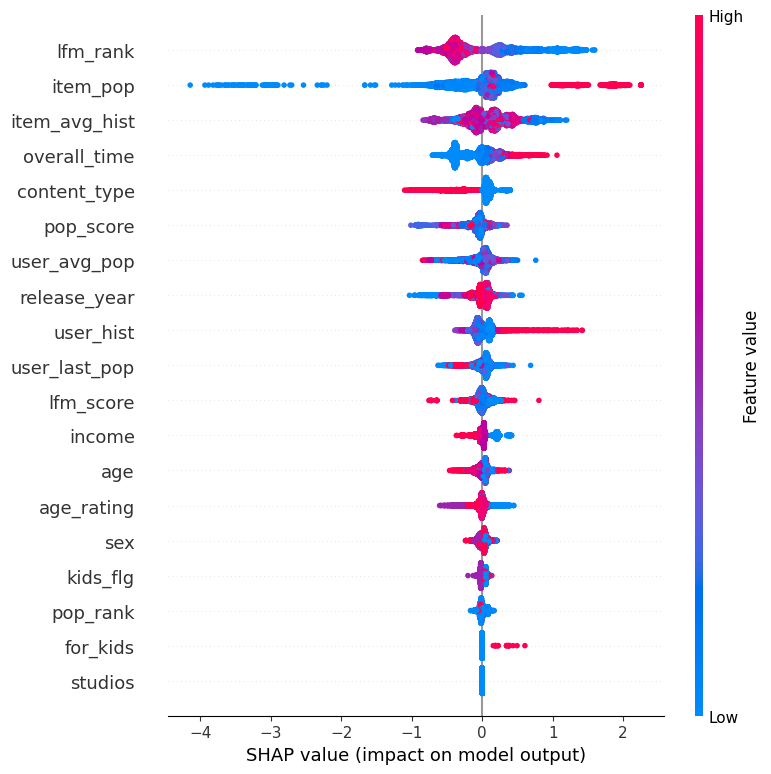

In [39]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

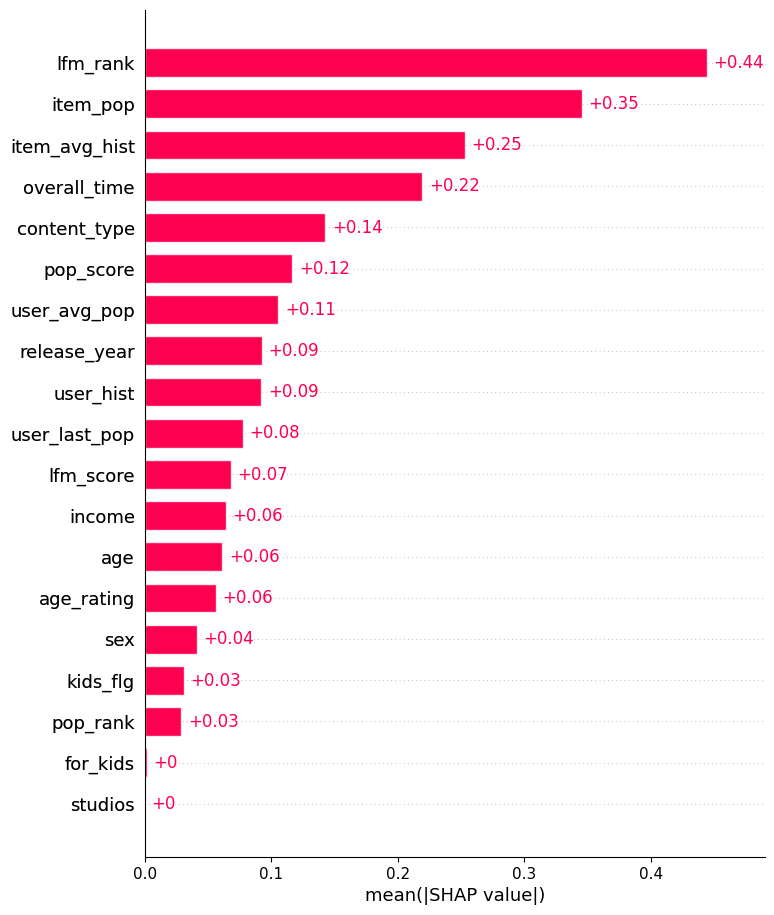

In [40]:
shap.plots.bar(shap_values, max_display=len(cols))

In [41]:
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test['target'])

y_pred

array([0.00099692, 0.01339248, 0.00047187, ..., 0.00112933, 0.00166235,
       0.07851032])

In [42]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    df[f'{name}_score'] = y_pred_scores
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    mask = (df['lfm_rank'] < 101).to_numpy()
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 101
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df


ranker_test = add_score_and_rank(ranker_test, y_pred, 'pointwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,lfm_score,lfm_rank,pop_score,pop_rank,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
29,53,9728,2021-07-01,0.0,0.0,1921451,-0.000035,2,242.99,2086.0,...,-1,18.0,-1,76978.0,11.165736,0,0.057527,1,0.057527,1
11,53,3734,2021-07-30,11529.0,100.0,1921452,-0.000035,3,50004.00,6.0,...,-1,16.0,-1,50004.0,12.134949,1,0.040850,2,0.040850,2
13,53,4151,2021-07-29,4302.0,13.0,1921450,-0.000034,1,69641.00,4.0,...,-1,18.0,-1,69641.0,10.807886,0,0.026507,3,0.026507,3


In [43]:
roc_auc_score(y_true, y_pred)

0.8505231211027551

In [44]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    )
)

(0.8613189852563174, 0.8613189852563174)

In [45]:
models_metrics['pointwise'] = calc_metrics_(ranker_test, 'pointwise_rank')
models_metrics['pointwise_hybrid'] = calc_metrics_(ranker_test, 'pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm', 'pop', 'pointwise', 'pointwise_hybrid']]

,lfm,pop,pointwise,pointwise_hybrid
Precision@10,0.024970,0.019554,0.025701,0.025701
recall@10,0.083588,0.065676,0.084463,0.084463
ndcg@10,0.031639,0.024170,0.033943,0.033943
map@10,0.042556,0.031365,0.046198,0.046198
novelty@10,3.135139,3.136589,3.406484,3.406484


#### Исправляем баг в users_filter

In [46]:
def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['lfm_rank'] <= 50]


ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

In [ ]:
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'categorical_feature': cat_cols,
    'feature_name': cols,
}

pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)
print(pointwise_model.best_score_['valid_0'])

In [48]:
pickle.dump(pointwise_model, open("models/pointwise_model.pkl", "wb"))

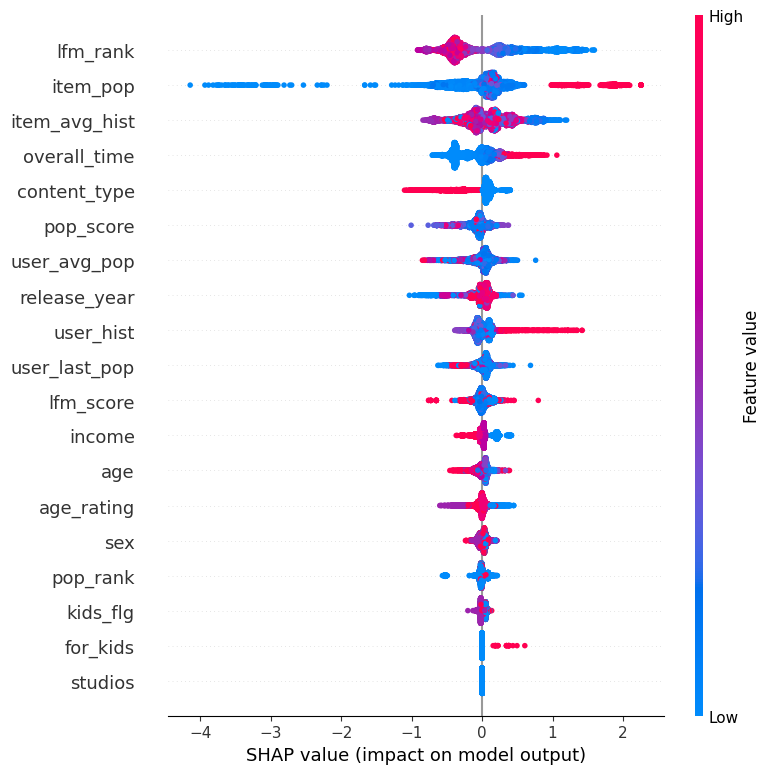

In [49]:
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap_values.values = shap_values.values[:, :, 1]
shap_values.base_values = shap_values.base_values[:, 1]

shap.plots.beeswarm(shap_values, max_display=len(cols))

In [50]:
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
ranker_test = add_score_and_rank(ranker_test, y_pred, 'fixed_pointwise')

models_metrics['fixed_pointwise'] = calc_metrics_(ranker_test, 'fixed_pointwise_rank')
models_metrics['fixed_pointwise_hybrid'] = calc_metrics_(ranker_test,
                                                         'fixed_pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm', 'fixed_pointwise_hybrid', 'pointwise_hybrid']]

,lfm,fixed_pointwise_hybrid,pointwise_hybrid
Precision@10,0.024970,0.025701,0.025701
recall@10,0.083588,0.084463,0.084463
ndcg@10,0.031639,0.033943,0.033943
map@10,0.042556,0.046198,0.046198
novelty@10,3.135139,3.406484,3.406484


### Pairwise/Listwise

In [51]:
def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [52]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,lfm_score,lfm_rank,pop_score,pop_rank,...,overall_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target,target_ranker
0,3,101,2021-07-01,0.0,0.0,27467084,0.000001,35,242.99,2086.0,...,0.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0,0
1,3,142,2021-08-13,5892.0,100.0,27467058,0.000004,9,35862.00,8.0,...,0.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1,2
2,3,849,2021-07-01,0.0,0.0,27467072,0.000002,23,13304.00,26.0,...,0.0,0,2018.0,-1,18.0,-1,13304.0,16.444678,0,0


In [ ]:
early_stopping_rounds = 32
params = {
    'objective': 'lambdarank',
    'n_estimators': 10000,
    'max_depth': 4,
    'num_leaves': 10,
    'min_child_samples': 100,
    'learning_rate': 0.25,
    'reg_lambda': 1,
    'colsample_bytree': 0.9,
    'early_stopping_rounds': early_stopping_rounds,
    'verbose': early_stopping_rounds // 8,
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

In [54]:
pickle.dump(listwise_model, open("models/listwise_model.pkl", "wb"))

In [55]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.7581014982549259),
             ('ndcg@5', 0.7818286604298739),
             ('ndcg@10', 0.8008224991905664)])

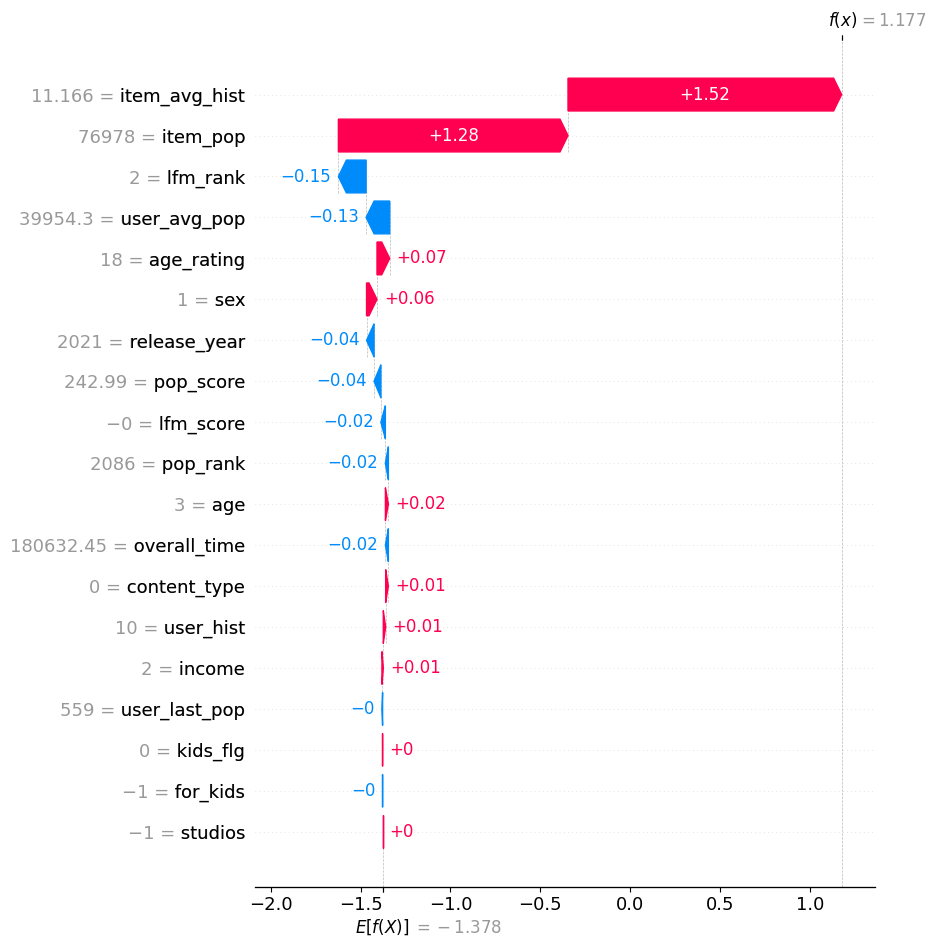

In [56]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

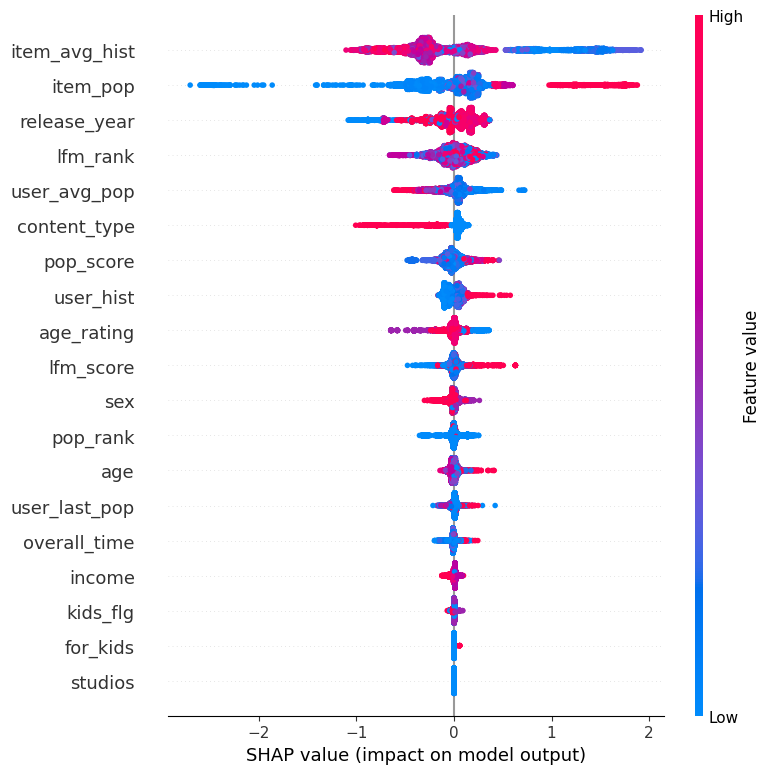

In [57]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

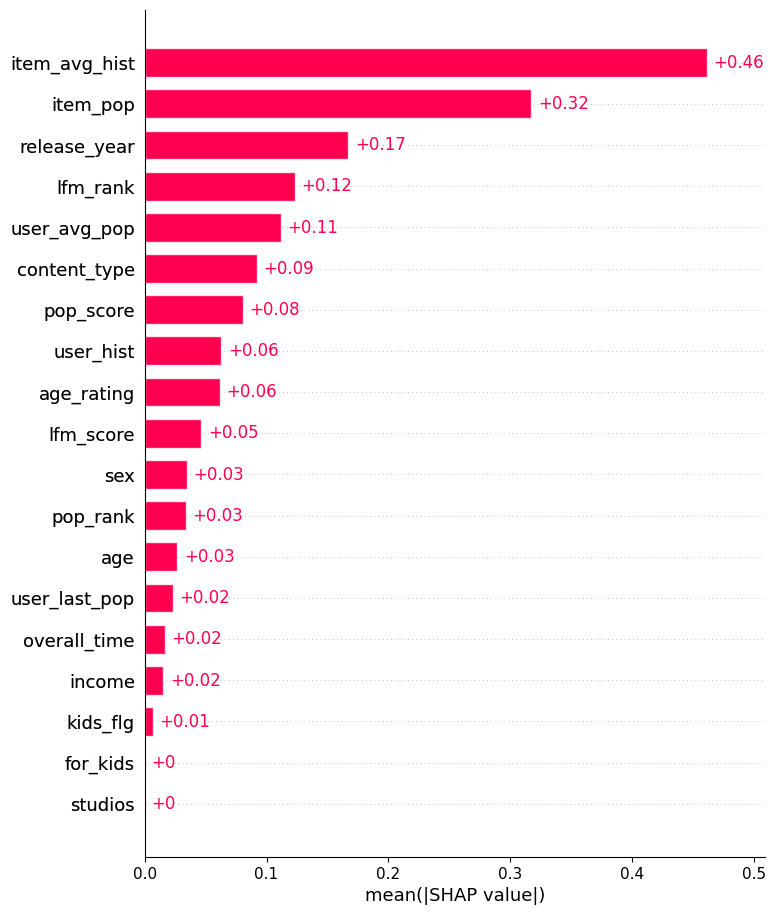

In [58]:
shap.plots.bar(shap_values, max_display=len(cols))

In [59]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,lfm_score,lfm_rank,pop_score,pop_rank,...,pointwise_hybrid_rank,fixed_pointwise_score,fixed_pointwise_rank,fixed_pointwise_hybrid_score,fixed_pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
29,53,9728,2021-07-01,0.0,0.0,1921451,-0.000035,2,242.99,2086.0,...,1,0.057527,1,0.057527,1,0,1.176707,1,1.176707,1
38,53,12192,2021-07-01,0.0,0.0,1921476,-0.000039,27,14317.00,23.0,...,13,0.004509,13,0.004509,13,0,0.877044,2,0.877044,2
11,53,3734,2021-07-30,11529.0,100.0,1921452,-0.000035,3,50004.00,6.0,...,2,0.040850,2,0.040850,2,2,0.788752,3,0.788752,3


In [60]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise', 'listwise_hybrid']]

,listwise,listwise_hybrid
Precision@10,0.027887,0.027887
recall@10,0.093060,0.093060
ndcg@10,0.036341,0.036341
map@10,0.050225,0.050225
novelty@10,3.424738,3.424738


In [61]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),  # target_ranker
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.8563249672402979, 0.8563249672402979)

In [62]:
ranker_df = pd.concat([ranker_train, ranker_val, ranker_test])

## Итоговые метрики

In [63]:
pd.DataFrame(models_metrics)[['lfm', 'fixed_pointwise_hybrid', 'listwise_hybrid']]

,lfm,fixed_pointwise_hybrid,listwise_hybrid
Precision@10,0.024970,0.025701,0.027887
recall@10,0.083588,0.084463,0.093060
ndcg@10,0.031639,0.033943,0.036341
map@10,0.042556,0.046198,0.050225
novelty@10,3.135139,3.406484,3.424738


Метрики у listwise лучше, берём её

## Оффлайн рекомендации

In [64]:
y_pred: np.ndarray = listwise_model.predict(ranker_df[cols])
ranker_df = add_score_and_rank(ranker_df, y_pred, "listwise")
ranker_df.head()

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,lfm_score,lfm_rank,pop_score,pop_rank,...,pointwise_hybrid_score,pointwise_hybrid_rank,fixed_pointwise_score,fixed_pointwise_rank,fixed_pointwise_hybrid_score,fixed_pointwise_hybrid_rank,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
49,3,15297,2021-07-01,0.0,0.0,27467050,0.000009,1,137128.00,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.708409,1,2.708409,1
28,3,10440,2021-07-23,44827.0,90.0,27467051,0.000008,2,141889.00,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.789801,2,1.789801,2
26,3,9728,2021-07-23,10448.0,100.0,27467054,0.000006,5,242.99,2086.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.745380,3,1.745380,3
41,3,13865,2021-07-01,0.0,0.0,27467052,0.000006,3,93403.00,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.432819,4,1.432819,4
36,3,12192,2021-08-11,11499.0,15.0,27467078,0.000001,29,14317.00,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.650546,5,0.650546,5


In [65]:
N_RECS = 10
ranker_df = ranker_df[[Columns.User, Columns.Item, "listwise_hybrid_rank"]]

res = (
    ranker_df.sort_values([Columns.User, "listwise_hybrid_rank"])
    .groupby(Columns.User)
    .head(N_RECS)
)
res.drop("listwise_hybrid_rank", axis=1, inplace=True)
res.head()

,user_id,item_id
49,3,15297
28,3,10440
26,3,9728
41,3,13865
36,3,12192


In [66]:
recs = res.groupby(Columns.User).agg(list).to_dict()[Columns.Item]

In [67]:
pickle.dump(recs, open("../saved_models/ranker.pkl", "wb"))